# Network Security 

**Team Member:** **Yucheol-Shin**, **Ricco Ferraro**

# Business Understanding

Cyber-security is a task most companies must tackle. Protecting data, networks and devices from hackers is becoming more challenging everyday. To ensure the safety of a network, it is important to handle this problem with care. Even a single hacker can result in a take over, resulting in significant repercussions. Using machine learning, to predict at a firewall level, when incoming connections are malicious helps solve this problem, increase security, reduce maintenance and allow the security team to focus on more extreme attacks and vulnerabilities.

A firewall is a barrier set between a private network and public network, it can protect sensitive information by monitoring and filtering network traffic connection requests. The goal of this case study is to build a model to predict whether to accept or deny internet access requests. 

In this study we use over 60 thousand network connection records to build this model. In this data, the feature 'Action' represents whether or not a connection was "accepted" or "not accepted" 


In [39]:
# imports 
import pandas as pd
from scipy.io import arff
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline
import spacy
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import glob, os  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [ ]:
#change directory folder
#Chris' path
curPath = os.getcwd().replace("\\", "/")
os.chdir(curPath+"/data")

# Ricco's Path
# os.chdir("QTW/log2.csv")

In [2]:
# Helper function to get feature names back from column transformer/scaler.
# From: https://johaupt.github.io/blog/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            print("Transformer %s (type %s) does not "
                  "provide get_feature_names. "
                  "Will return input column names if available"
                  % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

# Data Evaluation and Engineering

In this case study, we have a clean and structured dataset. There are 65,532 observations with no missing values. There are 4 actions taken in the target, `allow, deny, drop, reset-both`. We convert this problem to a binary classification problem by changing target variable to only `allow` and `not allowed`. Correlation among these features, distributions and linearity are analyzed in this section.

In [3]:
df = pd.read_csv("log2.csv")
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
df.describe(include = "all")

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,65532,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
unique,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,allow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,37640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,49391.969343,10577.385812,19282.972761,2671.049930,NaN,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,NaN,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,NaN,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,NaN,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,NaN,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,NaN,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000


### Missing Values

As can be seen there is no missing data in this dataset. 

In [5]:
num_vars =df.columns[df.dtypes != 'object']
df[num_vars].isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

### Connection Actionf Distribution 

As can be seen the dataset has a somewhat balanced distribution of Allowed(1) vs Not Allowed(0) Connection Action. 

Text(0.5, 1.0, 'pkts_received Distrubtion')

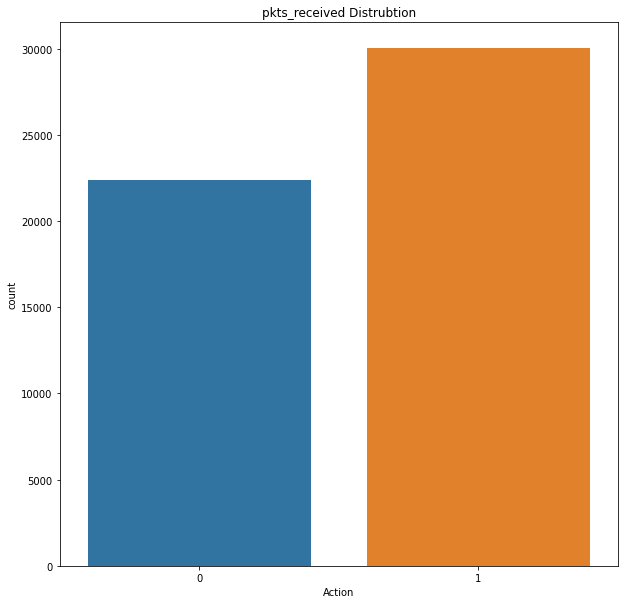

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.countplot(data=train, x='Action', ax=ax)
ax.set_title(f"{column} Distrubtion")

### Distribution of Source/Destination Ports

As can be seen below, the plot of source and detination ports shows Allowed and Not Allowed have similar distributions. Source Port is left skewed and Destination Port is right skewed. They are do appear to be peaks in source port distribution around 50000 and again 57000.

Text(0.5, 1.0, 'Destination Port Distrubtion by Action')

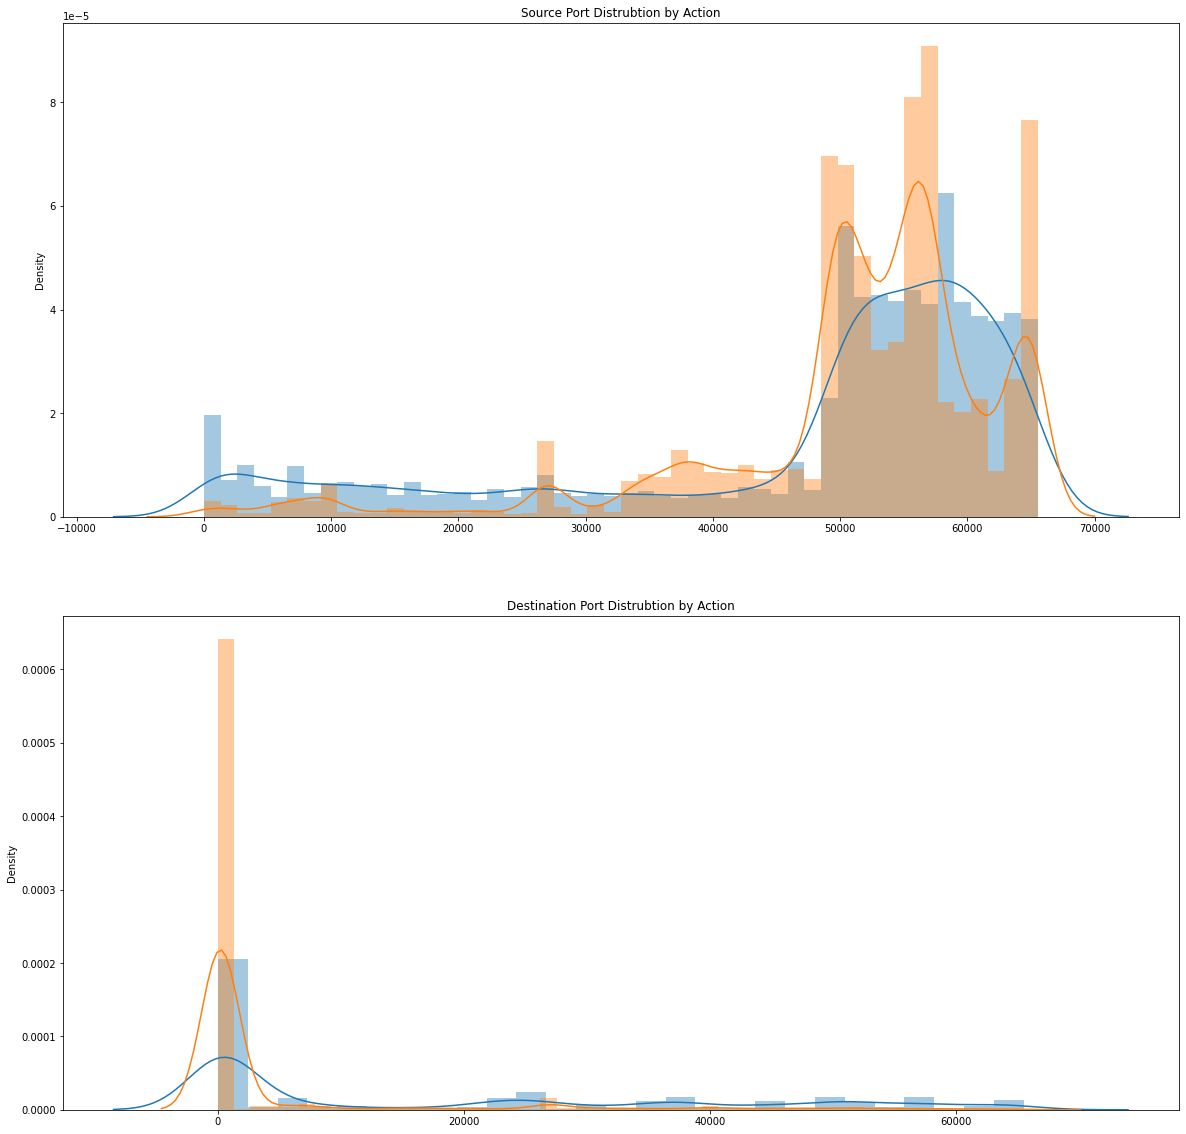

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))

df_action_0 = df[df['Action'] == 0]
df_action_1 = df[df['Action'] == 1]

ax = axes[0]
sns.distplot(x=df_action_0['Source Port'], ax=ax)
sns.distplot(x=df_action_1['Source Port'], ax=ax)
ax.set_title("Source Port Distrubtion by Action")

ax = axes[1]
sns.distplot(x=df_action_0['Destination Port'], ax=ax)
sns.distplot(x=df_action_1['Destination Port'], ax=ax)
ax.set_title("Destination Port Distrubtion by Action")

### Distribution of Bytes and Bytes Sent

As can be seen below, the plot of Bytes and Bytes Sent shows Allowed and Not Allowed have very different distributions that we see right skewed for Bytes and Bytes sent for Allowed cases but almost small distirbution for Not allowed.

(0.0, 400.0)

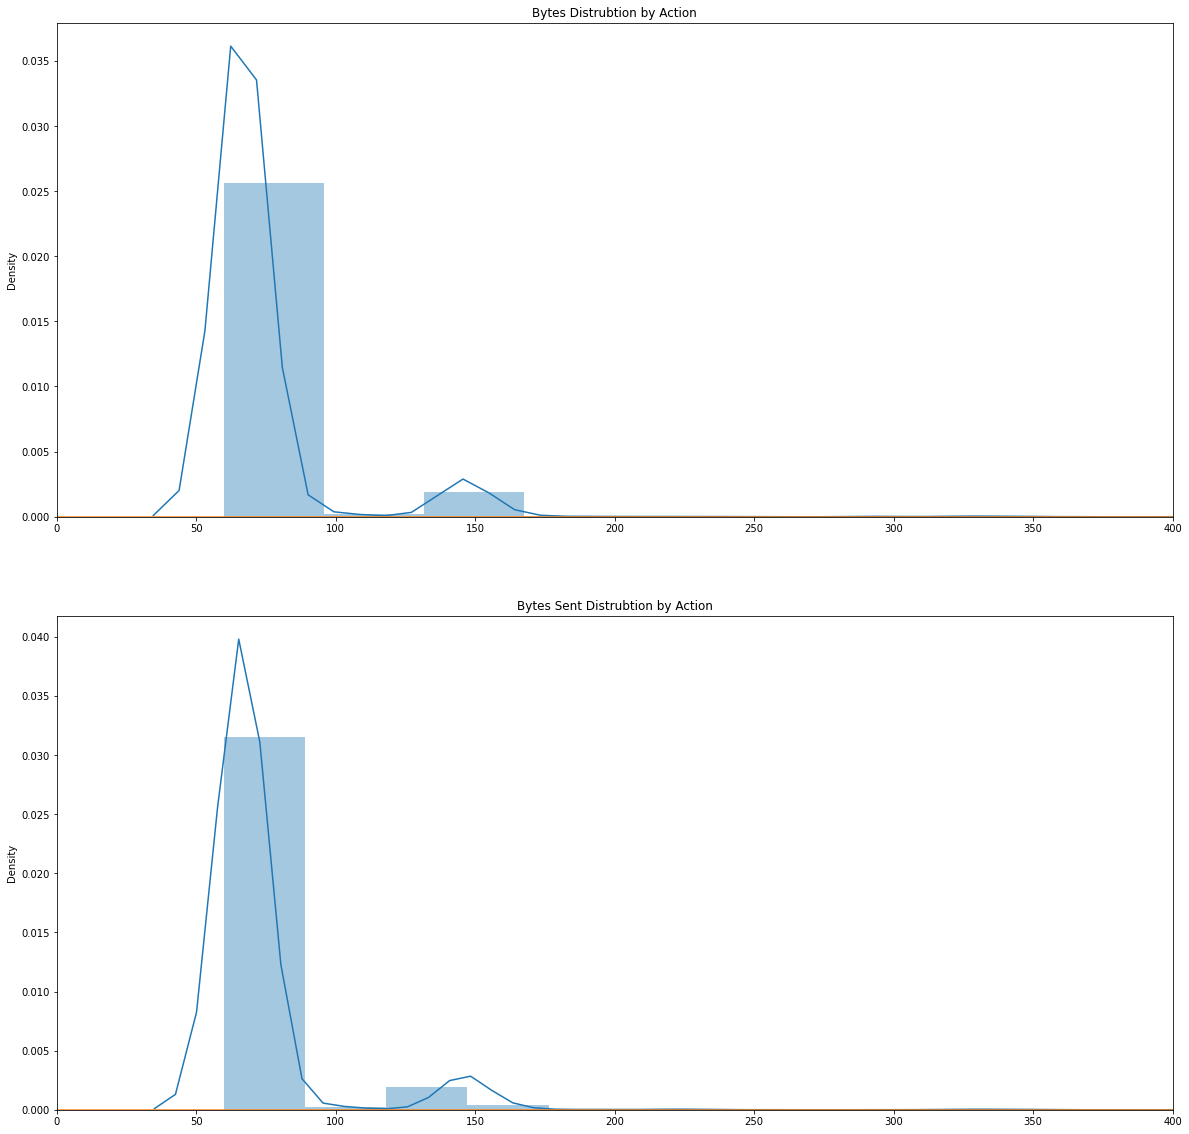

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))

df_action_0 = df[df['Action'] == 0]
df_action_1 = df[df['Action'] == 1]

ax = axes[0]
sns.distplot(x=df_action_0['Bytes'], ax=ax)
sns.distplot(x=df_action_1['Bytes'], ax=ax)
ax.set_title("Bytes Distrubtion by Action")
ax.set_xlim(0, 400)

ax = axes[1]
sns.distplot(x=df_action_0['Bytes Sent'], ax=ax)
sns.distplot(x=df_action_1['Bytes Sent'], ax=ax)
ax.set_title("Bytes Sent Distrubtion by Action")
ax.set_xlim(0, 400)

### Linearity Check by Scatter Plot

Since we found the data is highly skewed, it may require some kinds of transformation to make it more linearly seperated. 

As can be seen below, data are widely spread that it is hard to see the linear seperation.

(0.0, 1000.0)

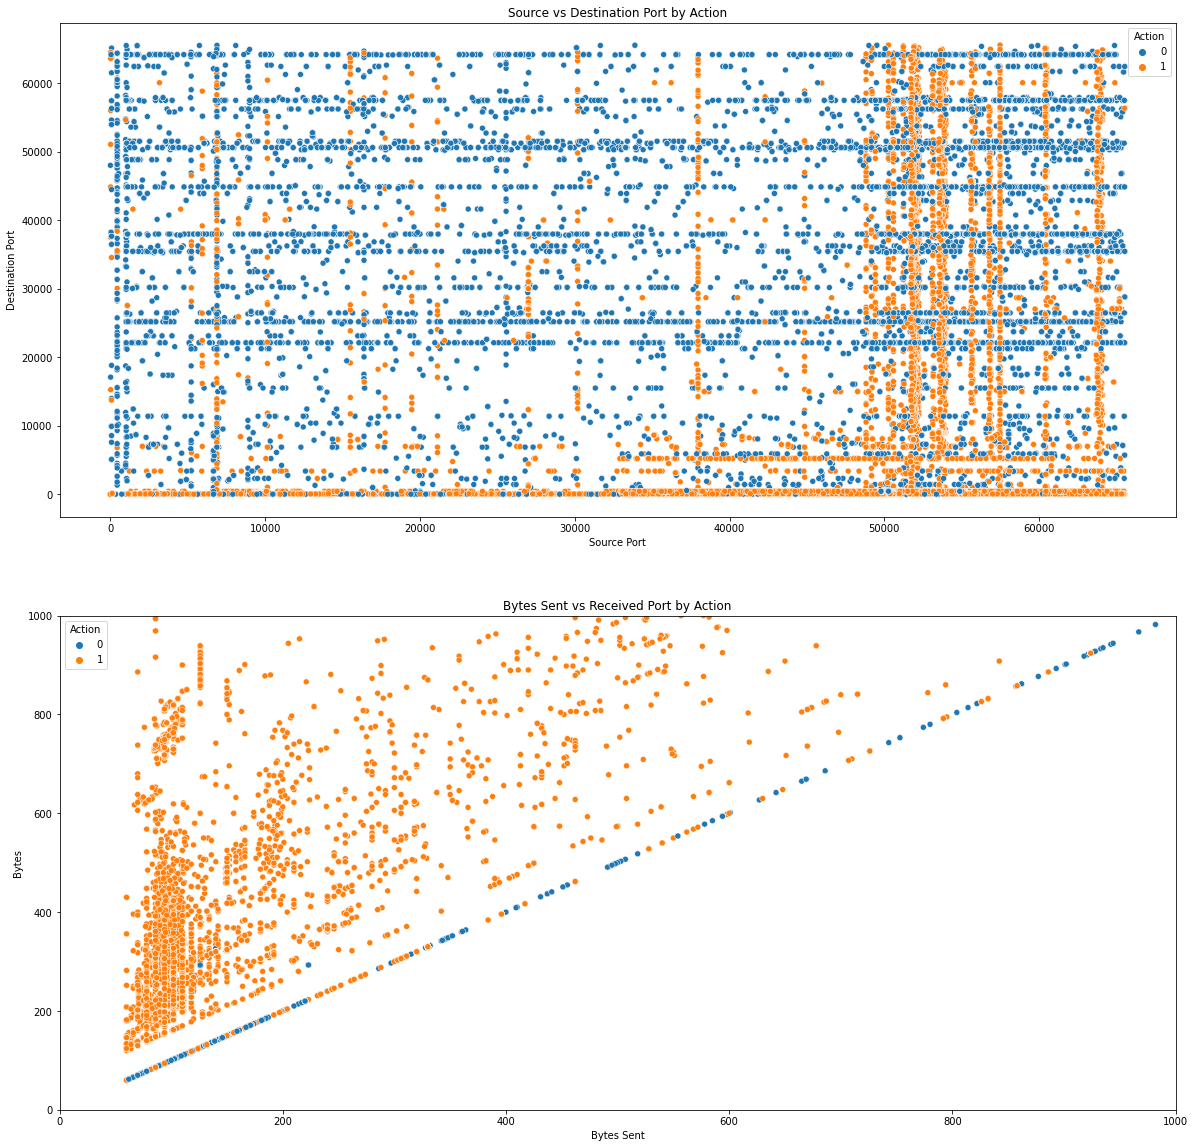

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,20))

ax = axes[0]
sns.scatterplot(data=df, x='Source Port', y='Destination Port', hue='Action', ax=ax)
ax.set_title("Source vs Destination Port by Action")

ax = axes[1]
sns.scatterplot(data=df, x='Bytes Sent', y='Bytes', hue='Action', ax=ax)
ax.set_title("Bytes Sent vs Received Port by Action")
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

## Features Selection
Lots of columns are mean of 0. Those are especially columsn related with the result of the access such as Bytes Received and Time Elapsed. This might be indication of causation of the failure on Action. Thus we can drop those columns.

In [14]:
train[train['Action'] == 0].describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,22343.000000,22343.000000,22343.000000,22343.000000,22343.0,22343.000000,22343.000000,22343.000000,22343.000000,22343.000000,22343.000000,22343.000000
mean,47058.928523,18590.664772,30.562682,2.815781,0.0,76.787316,76.649689,0.137627,1.003043,0.000269,1.002014,0.001029
std,18336.899630,21941.304862,1207.719169,128.186012,0.0,67.294759,66.110560,9.997323,0.087176,0.016385,0.053900,0.040682
min,0.000000,0.000000,0.000000,0.000000,0.0,60.000000,60.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,43683.500000,445.000000,0.000000,0.000000,0.0,62.000000,62.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,53833.000000,3389.000000,0.000000,0.000000,0.0,66.000000,66.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,59141.500000,37807.000000,0.000000,0.000000,0.0,70.000000,70.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,65533.000000,65504.000000,64014.000000,8889.000000,0.0,1850.000000,1514.000000,1419.000000,5.000000,1.000000,3.000000,2.000000


#### Feature Removal

Certain features are constants when Action is 0.This leads us to believe certain features are causal in nature based on the target action feature. As such we cannot include them in any analysis or model. 

Below are distribution plots where action is not allowed. The features, `Packets`, `Elapsed Time`, `Pkts_sent`, `NAT Source Port`, `NAT Destination Port`, `Bytes Received`, and `Pkts_received` displayed constants values with an impulse like distribution and are dropped.

`Bytes Received` may display constant value behavior, but due to the varying byte sizes of a single packet recieved there may be correlation. So at this time it is not safe to drop.

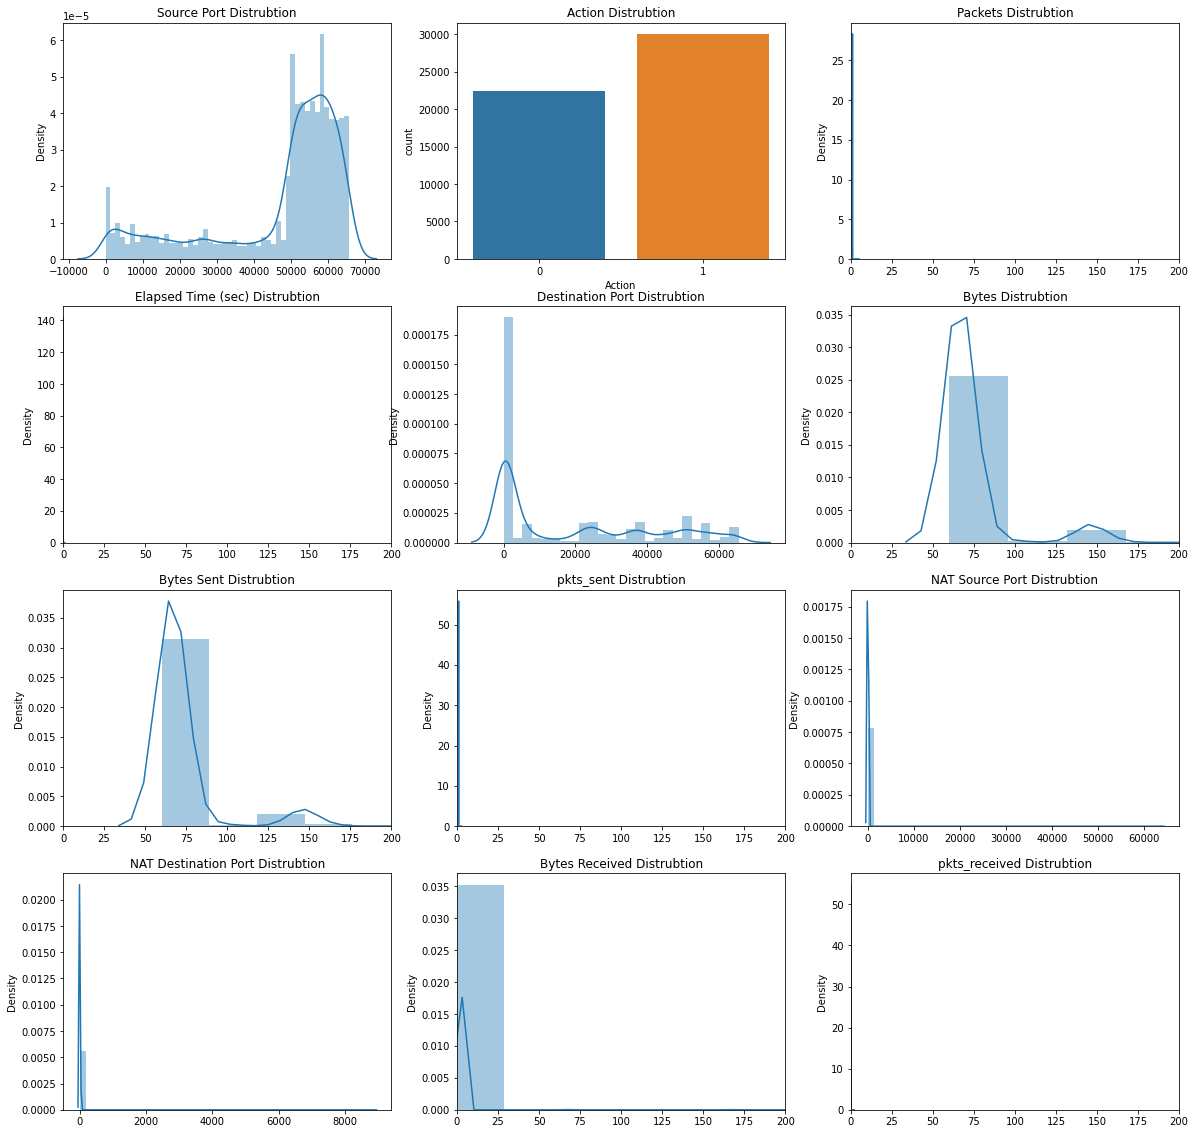

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

train_action_0 = train[train['Action'] == 0]
for i, column in enumerate(train.columns):
    row = i % 4
    col = i % 3
    ax = axes[row, col]
    if column == 'Action':
        sns.countplot(data=train, x='Action', ax=ax)
        ax.set_title(f"{column} Distrubtion")
    elif 'Port' in column:
        sns.distplot(x=train_action_0[column], ax=ax)
        ax.set_title(f"{column} Distrubtion")
    else:
        sns.distplot(x=train_action_0[column], ax=ax)
        ax.set_title(f"{column} Distrubtion")
        ax.set_xlim(0, 200)

In [48]:
train.drop(columns=['Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'NAT Source Port', 'NAT Destination Port', 'Bytes Received'], inplace=True)
test.drop(columns=['Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'NAT Source Port', 'NAT Destination Port', 'Bytes Received'], inplace=True)

## Model Preparation
### Proposed Methods
We prpose using Support Vector Machines to classify if incoming web connections will be allowed or not. One benefit to using Support Vector Machine is that they leverage a kernel trick and as such can project data that is otherwise not linearly seperable into higher dimenional space, thus achieving seperability via hyperplanes. Further, SVM is relatively memory efficient. Thus, kernels such as poly and rbf are leveraged to build our SVM model to classify whether or not a connection should be allowed. 

Although the kernel trick is a non linear transform and makes explainability difficult, given the rash implications of hacking for a business, rather than needing to explain or infer why a connection was refused, SVM does a powerful, flexible, and not very explainable job predicting firewall action. 


### Target Variable
Target is ``'Action'``, 1 is Allowed, 0 is Not Allowed.


### Scaling
In order to compare feature importances and to ensure the best predictive power, standardized z-score centering and scaling is performed on all explanatory features. 

### Feature Selection
Since the features represent network connection data, some of the features have a causal relationship with the Action of allowing or not allowing a connection. This means some features will be empty (or zero) as the result of rejected incoming network requests. For example, `bytes received` and `elapsed time` will be mostly zero when the incoming network connection is rejected as it will not reach the server. This causal relationship will highly impact the prediction of Not Allowed action but it is not known at the time the model we are building would need to provide a prediction. In our analysis we choose to leave out these features. This is outlined above in the feature selection section. 

### Test/Train split
In order to evaluate the quality of this binary classification problem, we choose a randomized ``80%/20%`` train/test split where 80% of the data is used for training and 5 fold cross validation, and the remaining 20% data is held out to evaluate test accuracy, test precision, test recall. By keeping a holdout set, and being careful not to allow any of that holdout 'test' set to leak into our model, including feature engineering, we can be more confident in the test metrics such as Precision, Recall, or Test ROC AUC.

### Evaluation Method
Because our case study is a binary classification problem, network 'Allowed' or 'Not Allowed', we can visualize the outcome of a binary classification model using a confusion matrix to generate metrics like precision and recall. Note: Test precision is considered more important than recall in this case, more on this below.

Catching hackers and preventing a breach is a high impact prediction. It is important to minimize the occurrence of classifying connections as "allowed" when they are indeed hackers and they should NOT be allowed. This sort of false positive, represents a hack. Thus we want to have higher precision where False Positive prevelance is small. For this reason, we choose ROC Area under the curve as a scoring technique to train the support vector machine model. This technique better facilitates thresholding which allows the optimum cutoff probabilities to be chosen which classify 'allowed' or 'not allowed' so that an optimal value of precision and recall can be chosen.
One tradeoff, by choosing to optimize for ROC AUC, is that predicive accuracy may decrease slightly.

After we evaluate the model with the ROC AUC score, we threshold our predictions to adjust recall vs precision. In order to minimize false positives, we prioritize higher precision. 

For more information on ROC curves, accuracy, precision, recall, etc, please see [here](https://www.baeldung.com/cs/classification-model-evaluation)

### Target Conversion

Our target variable is when the action is allowed or not allowed. Thus, we represent all actions other than allow, for example, `deny`, `drop`, and `reset-both`, as 0. We represent `allow` as 1.

In [12]:
df['Action'].replace({'deny': 0, 'drop': 0, 'reset-both': 0, 'allow': 1}, inplace=True)

# Model Building & Evaluation

# Preprocessing

In [14]:
train, test = train_test_split(df, test_size=0.2)

### Scaling

In [49]:
X_train = train.drop(columns=['Action'])
X_test = test.drop(columns=['Action'])
y_train = train['Action']
y_test = test['Action']

In [50]:
t_slr = [('scale', MinMaxScaler(), X_train.columns)]
col_transform = ColumnTransformer(t_slr, remainder='passthrough')
col_transform.fit(X_train)
X_train_scaled_array = col_transform.transform(X_train)
X_test_scaled_array = col_transform.transform(X_test)
column_names = get_feature_names(col_transform)
X_train_scaled = pd.DataFrame(data=X_train_scaled_array, columns=column_names, index=X_train.index)
X_test_scaled = pd.DataFrame(data=X_test_scaled_array, columns=column_names, index=X_test.index)

Transformer scale (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available


SVM and SGD

## Suppor Vector Machine

Grid Search is used to apply parameter tuning and reduce the time of the execution. We specifically looked into `kernel`, which represents the nonlinear transformation of scaled data into a higher dimensional space where action is potentially more seperable. Kernels that were explored include the `radial basis function` and the `polynomial` kernel. 

Also the variable `C` which regularizes the influence of slack variables. In essence, how strong the boundary neeeds to be. Boundaries that are too strong, are potentially overfit.  A Higher value of `C` penalizes slack variables more creating a stronger fit. a lower value of `C` peanlizes slack variables less, and thus creates a smoother boundary. 

Additionally, `gamma`, which defines the influence of a single training point. Essentially, how far points can be from the boundary and still be considered support vectors. 

To speed up training we randomly subsamples our training data to a smaller dataset of 15,000 samples.  We also used the 5 fold cross validation on our randomly sub-sampled train data set. 

ROC AUC was used as the objective scoring function. This was done to best facilitate thresholding to achieve high precision and thus low false positive ratios in our model. 

As can be seen in the results below, a tuned rbf based svm model performs best with a test ROC-AUC score of 0.84. It did so with a C value of 100 gamma a 0.0001.

In [36]:
svm_subsampled_df.describe()

,scale__Source Port,scale__Destination Port,scale__Bytes,scale__Bytes Sent,scale__Bytes Received
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.762490,0.150125,7.674923e-05,4.284665e-06,2.909433e-04
std,0.225964,0.276072,9.251363e-04,4.281471e-05,3.570128e-03
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.754845,0.000809,7.877992e-09,1.054322e-08,0.000000e+00
50%,0.831416,0.006760,8.508232e-08,2.846668e-08,2.555458e-07
75%,0.894063,0.104997,5.420059e-07,1.391705e-07,1.877638e-06
max,0.999695,0.978820,2.263231e-02,9.039153e-04,8.685808e-02


In [52]:
print(f"missing from X {np.any(np.isnan(X_train_scaled))}")
print(f"missing from y {np.any(np.isnan(y_train))}")
y_train
X_train_scaled

missing from X False
missing from y False


,scale__Source Port,scale__Destination Port,scale__Bytes,scale__Bytes Sent,scale__Bytes Received
0,0.625690,0.076295,0.000000e+00,0.000000e+00,0.000000e+00
1,0.684332,0.305318,3.482073e-07,9.488895e-08,1.096977e-06
2,0.647954,0.857633,6.775073e-08,9.067166e-08,0.000000e+00
3,0.894772,0.090028,1.575598e-09,2.108643e-09,0.000000e+00
4,0.996658,0.000809,1.890718e-07,4.111854e-08,6.263989e-07
...,...,...,...,...,...
52420,0.836146,0.337438,4.726795e-09,6.325930e-09,0.000000e+00
52421,0.788903,0.001221,2.425870e-05,2.526155e-06,8.849676e-05
52422,0.792108,0.006760,1.953742e-07,1.349532e-07,3.739695e-07
52423,0.873516,0.006760,1.342347e-04,1.012043e-05,5.010973e-04


In [51]:
svm_subsampled_df = X_train_scaled.copy()
svm_subsampled_df['Action'] = y_train
svm_subsampled_df = svm_subsampled_df.sample(15000)
svm_subsampled_y = svm_subsampled_df['Action']
svm_subsampled_df = svm_subsampled_df.drop(columns=['Action'])

In [52]:
# poly grid
param_grid = {'C': [.000000001, .0001, .001, .01, 0.1, 1],
              'kernel': ['poly', 'rbf'], 
             }


svc = GridSearchCV(estimator = SVC(), param_grid = param_grid, scoring='roc_auc',n_jobs=-1, cv=5)
svc_kernel_search = svc.fit(svm_subsampled_df, svm_subsampled_y)

In [26]:
svc_kernel_search.best_params_, svc_kernel_search.best_score_

({'C': 0.1, 'kernel': 'poly'}, 0.9996554561777092)

In [65]:
# tuned rbf grid
param_grid = {'C': [10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'], #'poly', 'rbf', 'sigmoid'],
#               'epochs': [2,5,10],
              'probability': [True]
             }

svc = GridSearchCV(estimator = SVC(), param_grid = param_grid, scoring='roc_auc',n_jobs=-1, cv=5)
svc_rbf_search = svc.fit(svm_subsampled_df, svm_subsampled_y)

In [66]:
svc_rbf_search.best_params_, svc_rbf_search.best_score_

({'C': 100, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True},
 0.8421680532328855)

As can be seen above, the tuned RBF based SVM model performs slightly better than the polynomail variant of SVM. For this reason we proceed with the RBF based SVM model. 

Below, you can see the precision and recall for the rbf based SVM. Natively, with a threshold of 0.5, it performs with a precision of: 0.71  and a recall 0.65.

It also performs with test ROC AUC of 0.84

In [67]:
y_svc_rbf_pred = svc_rbf_search.best_estimator_.predict(X_test_scaled)

print(confusion_matrix(y_test, y_svc_rbf_pred))
print(classification_report(y_test,y_svc_rbf_pred))

[[2231 3281]
 [ 742 6853]]
              precision    recall  f1-score   support

           0       0.75      0.40      0.53      5512
           1       0.68      0.90      0.77      7595

    accuracy                           0.69     13107
   macro avg       0.71      0.65      0.65     13107
weighted avg       0.71      0.69      0.67     13107



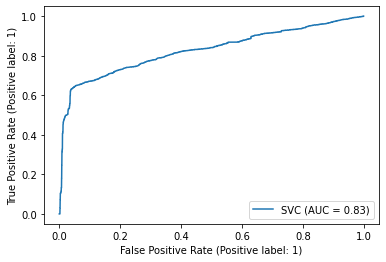

In [68]:
metrics.plot_roc_curve(svc_kernel_search.best_estimator_, X_test_scaled, y_test) ;

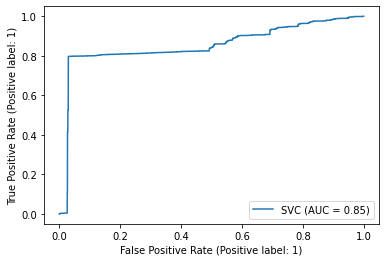

In [69]:
metrics.plot_roc_curve(svc_rbf_search.best_estimator_, X_test_scaled, y_test) ;

Based on test ROC AUC, we choose the tuned SVM with a radial basis function as its kernel. 

### SVM with RBF kernel -  Recall vs Precision
Note: To threshold with SVM, platt scaling is required to transform distances from a hyperplane into probabilities. This transformation affects the ability of thresholding to produce the same  precision and recall scores, but values are similar none the less. 

As can be seen in the plot below, a threshold value of 0.65, achieves a higher precision without much sacrifice in recall. 

(0.06642335037804095, 0.7057436653863087)

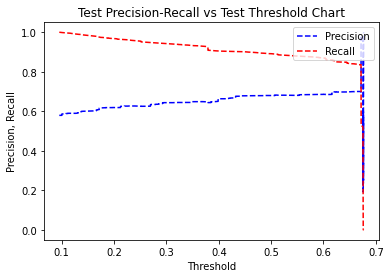

In [89]:
svm_rbf_pred_proba = svc_rbf_search.best_estimator_.predict_proba(X_test_scaled)
svm_rbf_result_df = pd.DataFrame(columns=['y_test', 'y_pred', 'y_proba_0', 'y_proba_1'])

svm_rbf_result_df['y_test'] = y_test
svm_rbf_result_df['y_pred'] = svm_rbf_pred_proba
svm_rbf_result_df['y_proba_0'] = svm_rbf_pred_proba[:,0]
svm_rbf_result_df['y_proba_1'] = svm_rbf_pred_proba[:,1]

# precision, recall, thresholds = precision_recall_curve(y_test, svm_rbf_pred_proba[:, 1]) 
plt.title("Test Precision-Recall vs Test Threshold Chart");
plt.plot(thresholds, precision[: -1], "b--", label="Precision");
plt.plot(thresholds, recall[: -1], "r--", label="Recall");
plt.ylabel("Precision, Recall");
plt.xlabel("Threshold");
plt.legend(loc="upper right");
plt.xlim()

##### Precision and Recall after tuning Threshold
After tuning the treshold with `0.6` we get the precision with `0.7` and recall with `0.84`.

In [94]:
svm_rbf_result_df.loc[svm_rbf_result_df[svm_rbf_result_df['y_proba_1'] > 0.65]['y_proba_1'].index, 'y_pred'] = 1
svm_rbf_result_df.loc[svm_rbf_result_df[svm_rbf_result_df['y_proba_1'] <= 0.65]['y_proba_1'].index, 'y_pred'] = 0

print(f'Recall with threshold 0.6 is {recall_score(y_test, svm_rbf_result_df.y_pred)}')
print(f'Precision with threshold 0.6 is {precision_score(y_test, svm_rbf_result_df.y_pred)}')

print('confusion matrix is \n{}\n'.format(confusion_matrix(y_test, svm_rbf_result_df.y_pred,  labels=[1,0])))

Recall with threshold 0.6 is 0.8414746543778802
Precision with threshold 0.6 is 0.6985462892119357
confusion matrix is 
[[6391 1204]
 [2758 2754]]



# Case Conclusions

In order to predict, at a firewall level, whether or not to allow a network connection through to a server an SVM model was trained in this analysis. This model levereaged a `radial basis function` as a kernel transform and trained on a supsample of 15,000 samples. 5-fold cross validation and a grid search was used to tune the model. The model favors a higher precision when the positive label for firewall action is to allow. This precision favoring is done to prevent hackers from gaining connection to valuable assets.  Our model predicted 'allow' or 'not allow' with a precision of .699 and a recall of .85. 

Future work could be done with more features, or with more data from various types of connection requests, recorded at different firewalls to make a predictive model such as the one outlined in this research generalize better. 